In [35]:
%reload_ext autoreload
%autoreload 2

from Scratch import metadata_loader
import numpy as np
from tqdm import tqdm

DEVICE = "ibm_sherbrooke"
LOGICAL = str(1)
XBASIS = False
ROUNDS = 100

state = "X" if XBASIS else "Z"
state += LOGICAL
print(f"state = {state}")


# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md[md["descr"] == 'subset RepCodes']
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]
md = md[md["xbasis"] == XBASIS]
md = md[md["rounds"] == ROUNDS]

md = md[md['notebook_name']=='Sherbrooke_RepCodes_jobs']

# md = md[0:1]
print("shape:", md.shape)
md[:2]


state = Z1
shape: (39, 18)


,creation_date,notebook_name,backend_name,job_id,tags,meas_level,shots,num_qubits,job_status,execution_date,code,distance,rounds,logical,descr,resets,xbasis,path_info
5287,2024-03-23 17:50:54.893000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqzggvks9z7g008dpg1g,"[Subset 52, 100 rounds, 1 log, xbasis=False]",1.0,768.0,NaN,JobStatus.DONE,2024-03-23 18:19:45.827751+01:00,RepetitionCodeCircuit,52,100,1,subset RepCodes,NaN,False,"{'mean_gate_error': 0.008345314216382, 'min_ga..."
5286,2024-03-23 17:50:40.025000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqzggqtk5z70008j0d80,"[Subset 52, 100 rounds, 1 log, xbasis=False]",1.0,768.0,NaN,JobStatus.DONE,2024-03-23 18:19:14.826963+01:00,RepetitionCodeCircuit,52,100,1,subset RepCodes,NaN,False,"{'mean_gate_error': 0.008345314216382, 'min_ga..."


In [36]:
from result_saver import SaverProvider

provider = SaverProvider()
md_loc = 0

job_id = md.iloc[md_loc]["job_id"]
job = provider.retrieve_job(job_id) 

execution_date = job.result().date
memory = job.result().get_memory()

print(f"Execution date: {execution_date}")

Execution date: 2024-03-23 18:19:45.827751+01:00


In [37]:
from soft_info import inv_qubit_mapping, get_repcode_IQ_map

_RESETS = False
SOFT_MUL = 0.5
T = md.iloc[md_loc]["rounds"]
d = md.iloc[md_loc]["distance"]

shots = md.iloc[md_loc]["shots"]
# Get the layout of the last job (same as previous)
layout_des = job.deserialize_layout(job.initial_layouts()[0]) # only 1 layout
link_qubits = list(layout_des['link_qubit'].values())
code_qubits = list(layout_des['code_qubit'].values())

# Get the pSoft and countMat matrices
big_layout = link_qubits + code_qubits
inverted_q_map = inv_qubit_mapping(get_repcode_IQ_map(big_layout, synd_rounds=T))

In [38]:
from Scratch import load_calibration_memory

all_memories_PS, _, msmt_err_dict = load_calibration_memory(provider, tobecalib_job=job_id, post_process=True, double_msmt=True)

Specified job execution date: 2024-03-23 18:19:45.827751+01:00
Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 17:20:48.312607+00:00.


# IQ Convertor

In [39]:
from typing import Tuple
import numpy as np

from tqdm import tqdm

from soft_info import fit_gmm_0_calib, process_gmm_data, get_gmm_RepCodeData, plot_RepCode_gmm
from sklearn.preprocessing import StandardScaler


qubit_list = [27, 44, 61, 69, 74, 80, 103, 107]
qubit_list = [27, 44]
qubit_list = [27, 80, 72, 14]

def GMMIQConvertor(IQ_data: np.ndarray, 
                   all_memories: dict, 
                   inverted_q_map: dict, 
                   plot: bool = False) -> Tuple[Tuple[np.ndarray], dict]:
    """
    This function takes in IQ data and converts it to a GMM representation. It uses the calibration data from the memories to fit the GMMs.
    The function returns the GMM representations of the IQ data and the GMMs used to convert the data.

    Parameters:
       - IQ_data (np.ndarray): The IQ data to be converted to GMM representation.
       - all_memories (dict): The calibration data from the memories.
       - inverted_q_map (dict): The mapping from physical qubits to the IQ data.
       - plot (bool): Whether to plot the GMM representations or not.

    Returns:
       - Tuple[Tuple[np.ndarray], dict]: (countMat, pSoft, estim0matrix, estim1matrix, estim2matrix), gmm_dict
                                    The GMM representations of the IQ data and the GMMs used to convert the data.
                                    
    """
    countMat = np.zeros_like(IQ_data, dtype=int)
    pSoft, estim0matrix, estim1matrix, estim2matrix = (np.zeros_like(IQ_data, dtype=float) for _ in range(4))

    gmm_dict = {}
    # for phys_idx, col_indices in inverted_q_map.items():
    for idx, (phys_idx, col_indices) in tqdm(enumerate(inverted_q_map.items())):
        # if phys_idx not in qubit_list:
        #     continue
        if idx > 5:
            break
        IQ_data_cols = IQ_data[:, col_indices].flatten()
        mmr_0 = all_memories[phys_idx]['mmr_0']

        IQ_data_proc, mmr_0_proc, _ = process_gmm_data(IQ_data_cols, mmr_0)
        gmm_0 = fit_gmm_0_calib(mmr_0_proc)
        gmm = get_gmm_RepCodeData(IQ_data_proc, gmm_0)
        gmm_dict[phys_idx] = gmm
        plot = plot_RepCode_gmm(IQ_data_proc, gmm) if plot else None

        probas = gmm.predict_proba(IQ_data_proc) + 1e-30

        # reorder to make sure 0, 1, 2 corresponds to states
        probas = reorder_gmm_components(gmm, probas, phys_idx)

        classifications = np.argmax(probas, axis=1)
        countMat[:, col_indices] = classifications.reshape(-1, len(col_indices))

        pSoft[:, col_indices] = (1 / (1 + np.max(probas[:, :2], axis=1) / np.min(probas[:, :2], axis=1))).reshape(-1, len(col_indices))   
        # pSoft[:, col_indices] = (1 / (1 + np.max(probas, axis=1) / np.min(probas, axis=1))).reshape(-1, len(col_indices))   

        estim0matrix[:, col_indices] = probas[:, 0].reshape(-1, len(col_indices))  
        estim1matrix[:, col_indices] = probas[:, 1].reshape(-1, len(col_indices)) if probas.shape[1] > 1 else None
        estim2matrix[:, col_indices] = probas[:, 2].reshape(-1, len(col_indices)) if probas.shape[1] > 2 else None
        

    return (countMat, pSoft, estim0matrix, estim1matrix, estim2matrix), gmm_dict

def reorder_gmm_components(gmm, probas, qubit):
    # Ensure Probas 0 corresponds to the component with the smallest x-value in its mean
    smallest_x_index = np.argmin(gmm.means_[:, 0])
    if smallest_x_index != 0:
        print(f"Reordering qubit {qubit}: Component with smallest x-value is not at index 0, but at index {smallest_x_index}.")
        new_order = np.arange(gmm.n_components)
        new_order[0], new_order[smallest_x_index] = new_order[smallest_x_index], new_order[0]
        probas = probas[:, new_order]

    # Check and reorder to ensure that for the two other modes the one with the lowest weight is 2
    if gmm.n_components > 2:
        if gmm.weights_[1] > gmm.weights_[2]:
            print(f"Reordering qubit {qubit}: Component at index 2 does not have the lowest weight.")
            probas[:, [1, 2]] = probas[:, [2, 1]]
    
    return probas
            

Reordering qubit 99: Component at index 2 does not have the lowest weight.
Reordering qubit 91: Component at index 2 does not have the lowest weight.
Reordering qubit 80: Component at index 2 does not have the lowest weight.
09:53:48 Warning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.. IN FILE: /Users/mha/.local/share/virtualenvs/Soft-Info-fMUpUe5a/lib/python3.11/site-packages/sklearn/mixture/_base.py, LINE: 268
09:54:20 Warning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.. IN FILE: /Users/mha/.local/share/virtualenvs/Soft-Info-fMUpUe5a/lib/python3.11/site-packages/sklearn/mixture/_base.py, LINE: 268
AIC relative difference above: 8.04251158103565e-06, below: 8.012336355069013e-06
Reordering qubit 61: Component at index 2 does not have the lowest weight.
AIC relative difference above: 3.411391714727327e-07, below: 9.220581729229413

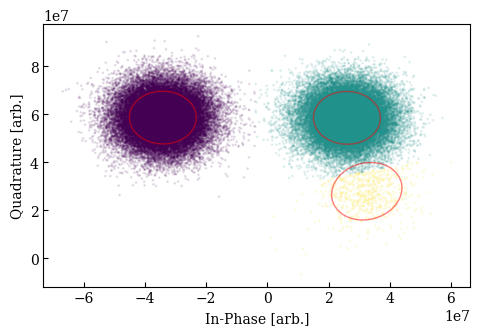

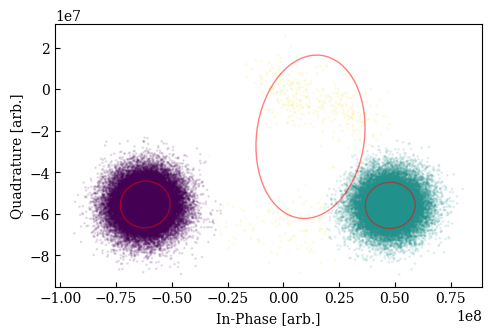

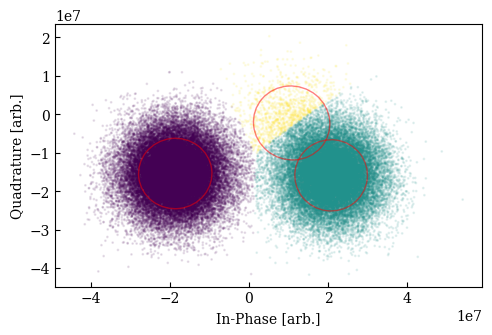

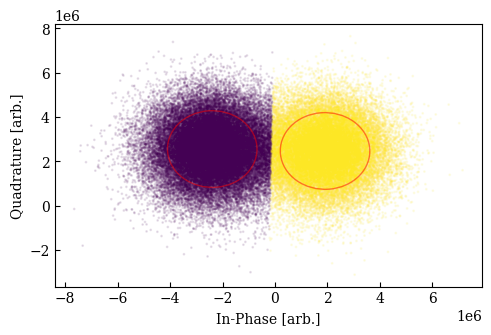

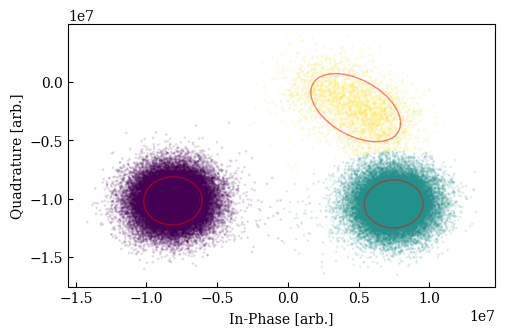

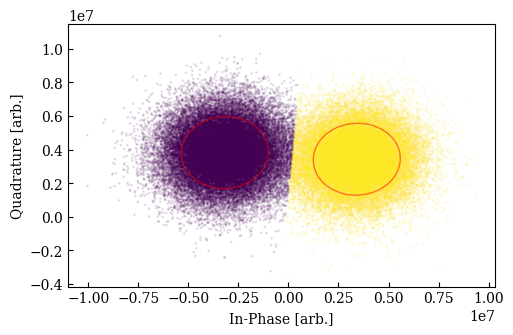

In [40]:
(countMat, pSoft, estim0matrix, estim1matrix, estim2matrix), gmm_dict = GMMIQConvertor(memory, all_memories_PS, inverted_q_map, plot=True)


Qubit 99
Shape countMat: (768, 100)
Unique countMat: (array([0, 1, 2]), array([42068,   666, 34066]))
mean pSoft: 0.0038407190407493312


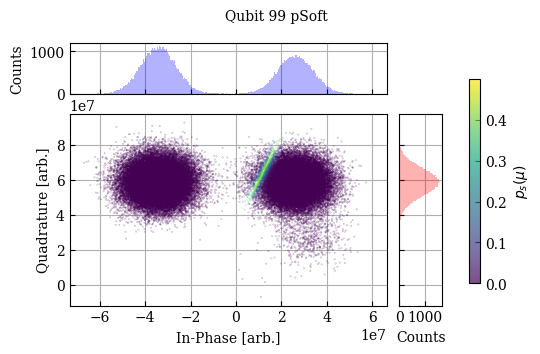

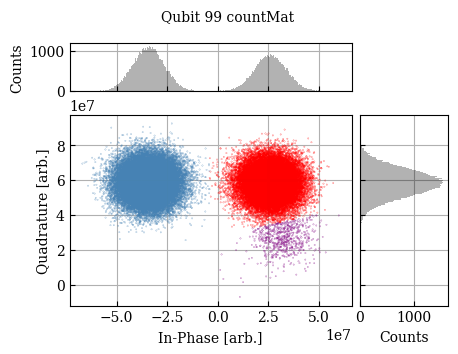


Qubit 91
Shape countMat: (768, 100)
Unique countMat: (array([0, 1, 2]), array([45268,   472, 31060]))
mean pSoft: 8.62121378147845e-05


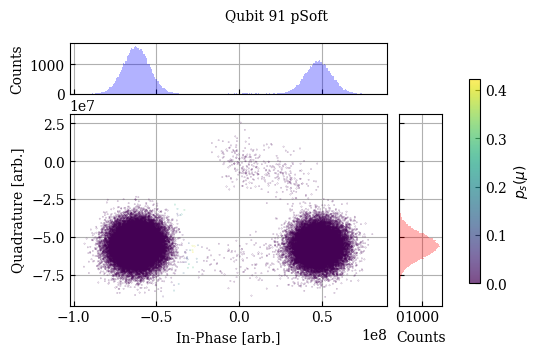

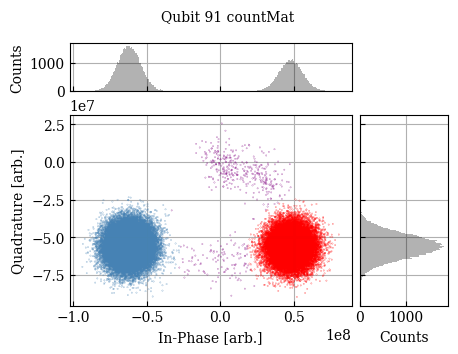


Qubit 80
Shape countMat: (768, 100)
Unique countMat: (array([0, 1, 2]), array([43213,  1082, 32505]))
mean pSoft: 0.004572824796748041


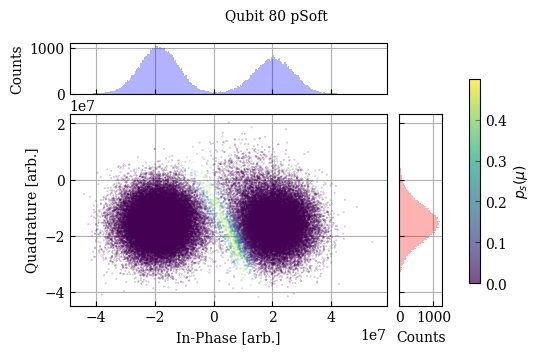

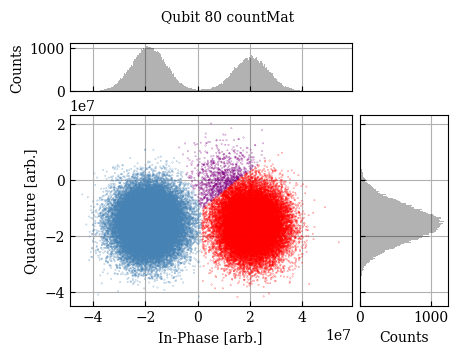


Qubit 72
Shape countMat: (768, 100)
Unique countMat: (array([0, 1]), array([44330, 32470]))
mean pSoft: 0.03690484927530617


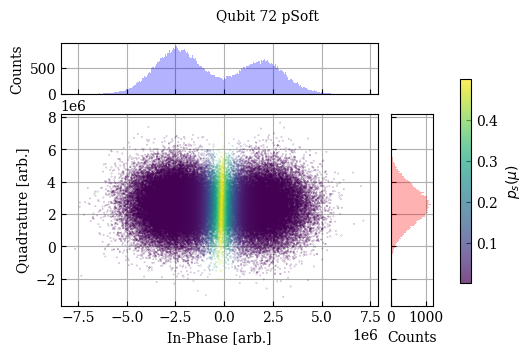

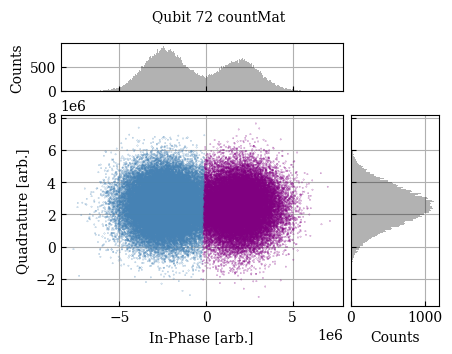


Qubit 61
Shape countMat: (768, 100)
Unique countMat: (array([0, 1, 2]), array([41509,  2738, 32553]))
mean pSoft: 4.956931417006907e-05


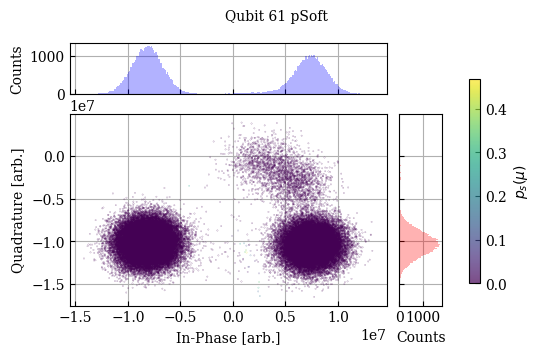

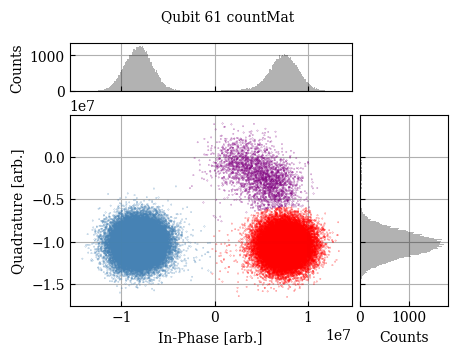


Qubit 59
Shape countMat: (768, 100)
Unique countMat: (array([0, 1]), array([41966, 34834]))
mean pSoft: 0.015615821293707555


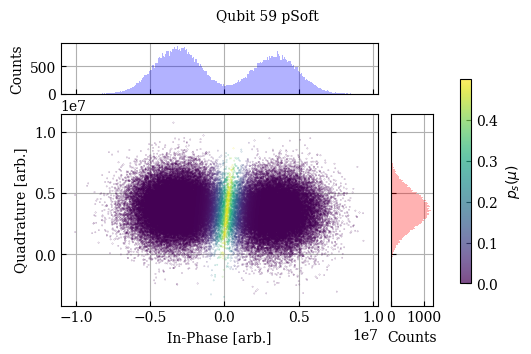

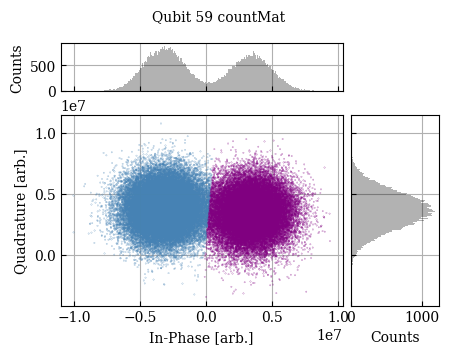

In [41]:
from soft_info import plot_IQ_data_pSoft_cmap, plot_IQ_data_with_countMat

# for qubit in qubit_list:
for idx, qubit in enumerate(inverted_q_map.keys()):
    if idx > 5:
        break
    cols = inverted_q_map[qubit]
    print(f"\nQubit {qubit}")
    print(f"Shape countMat: {countMat[:, cols].shape}")
    print(f"Unique countMat: {np.unique(countMat[:, cols], return_counts=True)}")
    print(f"mean pSoft: {np.mean(pSoft[:, cols])}")

    plot_IQ_data_pSoft_cmap(memory[:, cols], pSoft[:, cols], title=f"Qubit {qubit} pSoft")
    plot_IQ_data_with_countMat(memory[:, cols], countMat[:, cols], title=f"Qubit {qubit} countMat")
